# Future Sales Prediction - Kaggle Competition

https://www.kaggle.com/competitions/competitive-data-science-predict-future-sales/

#### File descriptions
- sales_train.csv - the training set. Daily historical data from January 2013 to October 2015.

- test.csv - the test set. You need to forecast the sales for these shops and products for November 2015.

- sample_submission.csv - a sample submission file in the correct format.

- items.csv - supplemental information about the items/products.

- item_categories.csv  - supplemental information about the items categories.

- shops.csv- supplemental information about the shops.

#### Data fields

- ID - an Id that represents a (Shop, Item) tuple within the test set

- shop_id - unique identifier of a shop

- item_id - unique identifier of a product

- item_category_id - unique identifier of item category

- item_cnt_day - number of products sold. You are predicting a monthly amount of this measure

- item_price - current price of an item

- date - date in format dd/mm/yyyy

- date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

- item_name - name of item

- shop_name - name of shop

- item_category_name - name of item category

### I. Import the dataset and data analysis libraries

In [207]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [208]:
sales_train = pd.read_csv("data/sales_train.csv")
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [209]:
test = pd.read_csv("data/test.csv")
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [210]:
sample_submission = pd.read_csv("data/sample_submission.csv")
sample_submission.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


In [211]:
items = pd.read_csv("data/items.csv")
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [212]:
item_categories = pd.read_csv("data/item_categories.csv")
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [213]:
shops = pd.read_csv("data/shops.csv")
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


### II. Initial data checks and manipulations

In [214]:
sales_train.shape

(2935849, 6)

In [215]:
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
 #   Column          Dtype  
---  ------          -----  
 0   date            object 
 1   date_block_num  int64  
 2   shop_id         int64  
 3   item_id         int64  
 4   item_price      float64
 5   item_cnt_day    float64
dtypes: float64(2), int64(3), object(1)
memory usage: 134.4+ MB


Note that the ```date``` column is not in the proper datetime format.

In [216]:
sales_train['date'] = pd.to_datetime(sales_train['date'], format = '%d.%m.%Y')
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [217]:
# Split into month, day, and year
sales_train['year'] = sales_train['date'].dt.year
sales_train['month'] = sales_train['date'].dt.month
sales_train['day'] = sales_train['date'].dt.day
sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15


In [218]:
# Keep the month-year pair (in string format) to make date_block_num column more intelligible
sales_train['month_year'] = sales_train['date'].dt.strftime('%Y-%m-%d').str[:7]

# dt.strftime(...) to convert the datetime format of 'date' into string format
# str[:7] to extract the month and year in the date string

sales_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,month_year
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2013-01
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,2013-01
2,2013-01-05,0,25,2552,899.00,-1.0,2013,1,5,2013-01
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,2013-01
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01


In [219]:
sales_train.isna().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
year              0
month             0
day               0
month_year        0
dtype: int64

In [220]:
sales_train.nunique()

date               1034
date_block_num       34
shop_id              60
item_id           21807
item_price        19993
item_cnt_day        198
year                  3
month                12
day                  31
month_year           34
dtype: int64

In [221]:
# Describing datetime and quantitative variables
sales_train[['date', 'item_price', 'item_cnt_day']].describe()

,date,item_price,item_cnt_day
count,2935849,2.935849e+06,2.935849e+06
mean,2014-04-03 05:44:34.970681344,8.908532e+02,1.242641e+00
min,2013-01-01 00:00:00,-1.000000e+00,-2.200000e+01
25%,2013-08-01 00:00:00,2.490000e+02,1.000000e+00
50%,2014-03-04 00:00:00,3.990000e+02,1.000000e+00
75%,2014-12-05 00:00:00,9.990000e+02,1.000000e+00
max,2015-10-31 00:00:00,3.079800e+05,2.169000e+03
std,NaN,1.729800e+03,2.618834e+00


In [222]:
# Declaring categorical variables
sales_train['shop_id'] = pd.Categorical(sales_train['shop_id'])
sales_train['item_id'] = pd.Categorical(sales_train['item_id'])

In [223]:
# Describing categorical variables
sales_train[['month_year', 'shop_id', 'item_id']].describe()

,month_year,shop_id,item_id
count,2935849,2935849,2935849
unique,34,60,21807
top,2013-12,31,20949
freq,143246,235636,31340


In [224]:
print(f'Number of item_cnt_day values below 0: {sales_train[sales_train['item_cnt_day'] < 0].shape[0]}')

Number of item_cnt_day values below 0: 7356


In [225]:
# Convert negative to positive values in item_cnt_day
sales_train['item_cnt_day'] = sales_train['item_cnt_day'].abs()

In [226]:
# Create a "master table" for EDA in training data
sales_full = sales_train.merge(items, how = 'inner', on = 'item_id')\
                              .merge(item_categories, how = 'inner', on = 'item_category_id')\
                              .merge(shops, how = 'inner', on = 'shop_id')

sales_full.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,year,month,day,month_year,item_name,item_category_id,item_category_name,shop_name
0,2013-01-02,0,59,22154,999.00,1.0,2013,1,2,2013-01,ЯВЛЕНИЕ 2012 (BD),37,Кино - Blu-Ray,"Ярославль ТЦ ""Альтаир"""
1,2013-01-03,0,25,2552,899.00,1.0,2013,1,3,2013-01,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
2,2013-01-05,0,25,2552,899.00,1.0,2013,1,5,2013-01,DEEP PURPLE The House Of Blue Light LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
3,2013-01-06,0,25,2554,1709.05,1.0,2013,1,6,2013-01,DEEP PURPLE Who Do You Think We Are LP,58,Музыка - Винил,"Москва ТРК ""Атриум"""
4,2013-01-15,0,25,2555,1099.00,1.0,2013,1,15,2013-01,DEEP PURPLE 30 Very Best Of 2CD (Фирм.),56,Музыка - CD фирменного производства,"Москва ТРК ""Атриум"""


### III. EDA for quantitative variables

Text(0.5, 1.03, 'Distribution of quantitative data')

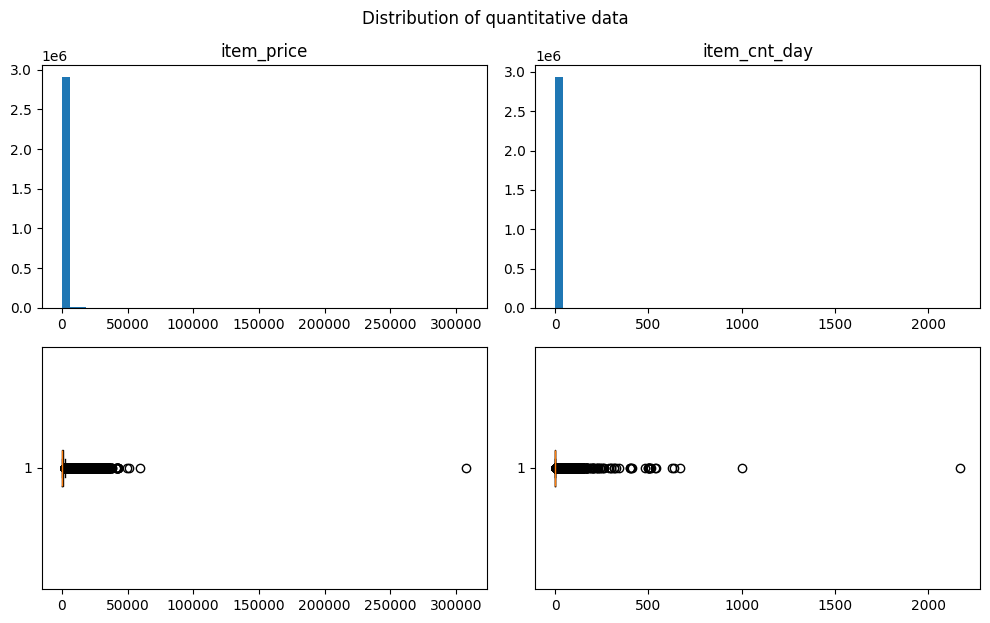

In [227]:
# Distribution of quantitative data
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (10, 6))
ax[0][0].hist(sales_full['item_price'], bins = 50)
ax[0][0].set_title('item_price')
ax[1][0].boxplot(sales_full['item_price'], vert = False)

ax[0][1].hist(sales_full['item_cnt_day'], bins = 50)
ax[0][1].set_title('item_cnt_day')
ax[1][1].boxplot(sales_full['item_cnt_day'], vert = False)

plt.tight_layout()
fig.suptitle('Distribution of quantitative data', y = 1.03)

### IV. EDA for categorical variables

In [228]:
# Top 10 highest priced item (with names) during 2013-2015
highest_priced = sales_full[['item_id', 'item_name', 'item_price']].copy() # keep only necessary columns
highest_priced.drop_duplicates(subset = ['item_id'], inplace = True) # drop duplicates
highest_priced = highest_priced.sort_values('item_price', ascending = False).iloc[:10] # sort for top 10

highest_priced

,item_id,item_name,item_price
1163158,6066,Radmin 3 - 522 лиц.,307980.0
1488135,13199,Коллекционные шахматы (Властелин Колец),50999.0
2327159,7241,UserGate Proxy & Firewall 6.X с модулем фильтр...,49782.0
2885692,13403,"Комплект ""Microsoft Xbox One 1TB Limited Edit...",42990.0
1006638,7238,UserGate Proxy & Firewall 6.X до 100 сессий,42000.0
2143903,14173,Лицензия 1С-Битрикс: Управление сайтом - Эксперт,40900.0
884848,2410,CorelDRAW Graphics Suite X6 - Small Business E...,36990.0
2890662,13448,Комплект Sony PlayStation 4 (1Tb) Black (CUH-1...,34990.0
2907568,13503,Комплект «Sony PlayStation 4 (1Tb) Black (CUH-...,34990.0
2113,5748,Photoshop 13 Windows Russian BOX,32990.0


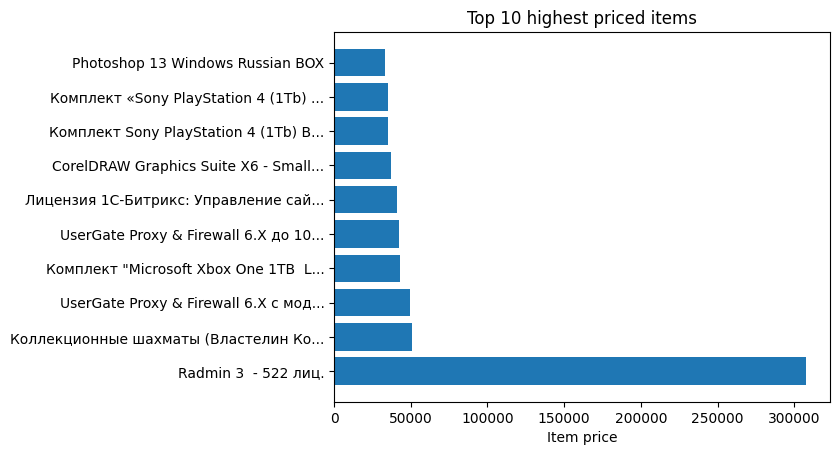

In [229]:
# Truncate item names to 35 characters because many of them are so long
highest_priced['item_name_trunc'] = highest_priced['item_name'].case_when([
    (highest_priced['item_name'].str.len() <= 35, highest_priced['item_name']),
    (highest_priced['item_name'].str.len() > 35, highest_priced['item_name'].str[:35] + "...")
])

fig, ax = plt.subplots()
ax.barh(highest_priced['item_name_trunc'], highest_priced['item_price'])

ax.set_xlabel('Item price')
ax.set_title('Top 10 highest priced items')
plt.show()

In [230]:
# Top 10 items with the most quantity sold
most_sold = sales_full[['item_id', 'item_name', 'item_cnt_day']].copy() # keep only necessary columns
most_sold = most_sold.groupby(['item_id', 'item_name']).sum()
most_sold = most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10] # sort for top 10
most_sold.reset_index(inplace = True)

most_sold

,item_id,item_name,item_cnt_day
0,20949,Фирменный пакет майка 1С Интерес белый (34*42)...,187678.0
1,2808,"Diablo III [PC, Jewel, русская версия]",17265.0
2,3732,"Grand Theft Auto V [PS3, русские субтитры]",16710.0
3,17717,Прием денежных средств для 1С-Онлайн,15830.0
4,5822,Playstation Store пополнение бумажника: Карта ...,14529.0
5,3734,"Grand Theft Auto V [Xbox 360, русские субтитры]",11778.0
6,6675,Sony PlayStation 4 (500 Gb) Black (CUH-1008A/1...,10341.0
7,3731,"Grand Theft Auto V [PC, русские субтитры]",10111.0
8,1855,"Battlefield 4 [PC, русская версия]",10050.0
9,16787,"Одни из нас [PS3, русская версия]",9283.0


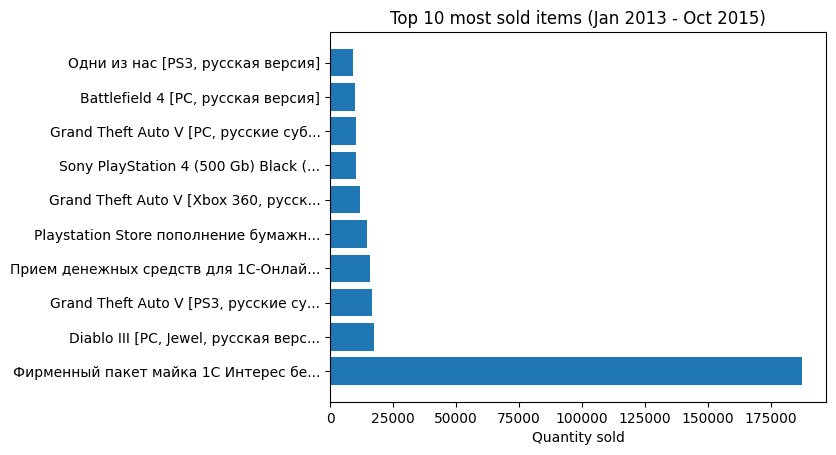

In [231]:
most_sold['item_name_trunc'] = most_sold['item_name'].case_when([
    (most_sold['item_name'].str.len() <= 35, most_sold['item_name']),
    (most_sold['item_name'].str.len() > 35, most_sold['item_name'].str[:35] + "...")
])

fig, ax = plt.subplots()
ax.barh(most_sold['item_name_trunc'], most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 most sold items (Jan 2013 - Oct 2015)')
plt.show()

In [232]:
print(f'Full name of the most sold item: {most_sold.iloc[0, 1]}')

Full name of the most sold item: Фирменный пакет майка 1С Интерес белый (34*42) 45 мкм


In [233]:
# Item category with highest median price
cat_highest_medprice = sales_full[['item_category_id', 'item_category_name', 'item_price']].copy() # keep only necessary columns

# Summarize median price of different item categories
cat_highest_medprice = cat_highest_medprice.groupby(['item_category_id', 'item_category_name']).median()
# Sort the median prices in descending order and keep the top 10
cat_highest_medprice = cat_highest_medprice.sort_values('item_price', ascending = False).iloc[:10]

cat_highest_medprice.reset_index(inplace = True)
cat_highest_medprice

,item_category_id,item_category_name,item_price
0,12,Игровые консоли - PS4,22990.0
1,16,Игровые консоли - XBOX ONE,20499.0
2,11,Игровые консоли - PS3,13490.0
3,15,Игровые консоли - XBOX 360,11491.0
4,14,Игровые консоли - PSVita,9490.0
5,13,Игровые консоли - PSP,4589.4
6,7,Аксессуары - XBOX ONE,2840.0
7,20,Игры - PS4,2799.0
8,74,Программы - MAC (Цифра),2780.0
9,2,Аксессуары - PS3,2390.0


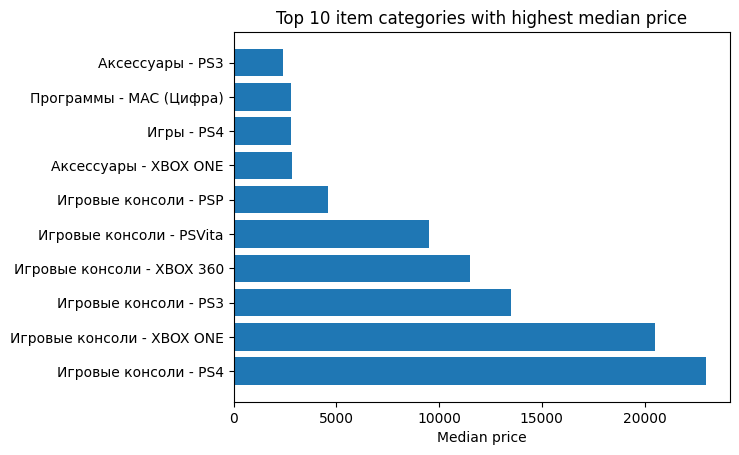

In [234]:
fig, ax = plt.subplots()
ax.barh(cat_highest_medprice['item_category_name'], cat_highest_medprice['item_price'])

ax.set_xlabel('Median price')
ax.set_title('Top 10 item categories with highest median price')
plt.show()

In [235]:
# Top 10 item categories with the most quantity sold
cat_most_sold = sales_full[['item_category_id', 'item_category_name', 'item_cnt_day']].copy()
cat_most_sold = cat_most_sold.groupby(['item_category_id', 'item_category_name']).sum()
cat_most_sold = cat_most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10]
cat_most_sold.reset_index(inplace = True)

cat_most_sold

,item_category_id,item_category_name,item_cnt_day
0,40,Кино - DVD,635599.0
1,30,Игры PC - Стандартные издания,458178.0
2,55,Музыка - CD локального производства,349509.0
3,19,Игры - PS3,256627.0
4,37,Кино - Blu-Ray,204778.0
5,71,"Подарки - Сумки, Альбомы, Коврики д/мыши",188034.0
6,28,Игры PC - Дополнительные издания,175500.0
7,23,Игры - XBOX 360,171210.0
8,20,Игры - PS4,128207.0
9,65,Подарки - Настольные игры (компактные),73129.0


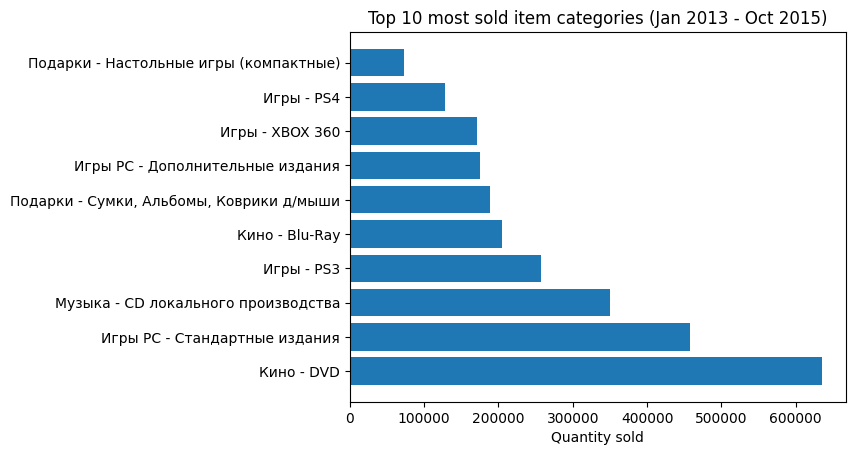

In [236]:
fig, ax = plt.subplots()
ax.barh(cat_most_sold['item_category_name'], cat_most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 most sold item categories (Jan 2013 - Oct 2015)')
plt.show()

In [237]:
# Top 10 shops with the most quantity sold
shop_most_sold = sales_full[['shop_id', 'shop_name', 'item_cnt_day']].copy()
shop_most_sold = shop_most_sold.groupby(['shop_id', 'shop_name']).sum()
shop_most_sold = shop_most_sold.sort_values('item_cnt_day', ascending = False).iloc[:10]
shop_most_sold.reset_index(inplace = True)

shop_most_sold

,shop_id,shop_name,item_cnt_day
0,31,"Москва ТЦ ""Семеновский""",311683.0
1,25,"Москва ТРК ""Атриум""",242554.0
2,54,"Химки ТЦ ""Мега""",186508.0
3,28,"Москва ТЦ ""МЕГА Теплый Стан"" II",184997.0
4,42,"СПб ТК ""Невский Центр""",145456.0
5,57,"Якутск Орджоникидзе, 56",141741.0
6,27,"Москва ТЦ ""МЕГА Белая Дача II""",136973.0
7,6,"Воронеж (Плехановская, 13)",101025.0
8,58,"Якутск ТЦ ""Центральный""",82082.0
9,46,"Сергиев Посад ТЦ ""7Я""",79194.0


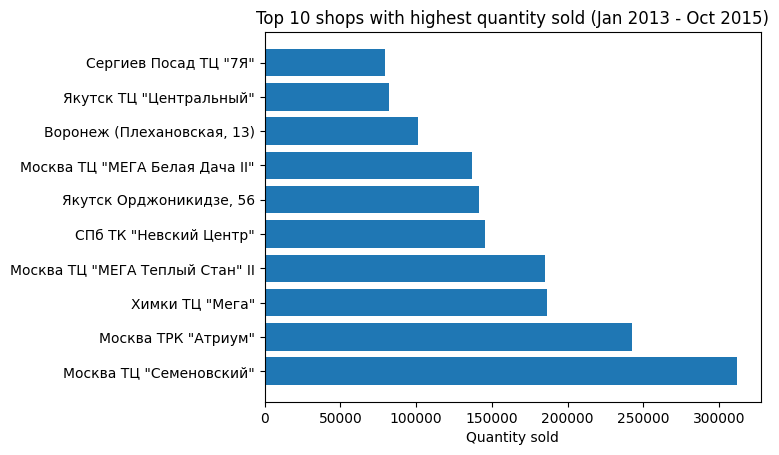

In [238]:
fig, ax = plt.subplots()
ax.barh(shop_most_sold['shop_name'], shop_most_sold['item_cnt_day'])

ax.set_xlabel('Quantity sold')
ax.set_title('Top 10 shops with highest quantity sold (Jan 2013 - Oct 2015)')
plt.show()

### V. Adding the time series element

In [239]:
# https://blog.finxter.com/5-effective-ways-to-check-missing-dates-in-pandas/
# https://stackoverflow.com/questions/18176933/create-an-empty-data-frame-with-index-from-another-data-frame

# What date is missing?
# Extract only the dates in the data of sales recorded (sales_dates)
sales_dates = sales_full[['date']].copy()
sales_dates.drop_duplicates(inplace = True)

# Create a DataFrame containing all possible dates within the "min sale date" and "max sale date" (full_dates)
dates_indexer = pd.date_range(start = min(sales_dates['date']), end = max(sales_dates['date'])) # returns a DateTime index
full_dates = pd.DataFrame(index = dates_indexer)
full_dates.reset_index(inplace = True) # for better merging

# Now join full_dates with sales_dates to check if there is any NaT values
check_dates = full_dates.merge(sales_dates, left_on = 'index', right_on = 'date', how = 'left')
check_dates.head()

,index,date
0,2013-01-01,2013-01-01
1,2013-01-02,2013-01-02
2,2013-01-03,2013-01-03
3,2013-01-04,2013-01-04
4,2013-01-05,2013-01-05


In [240]:
check_dates.isna().sum()

index    0
date     0
dtype: int64

All possible dates between the "min sale date" and "max sale date" has a record in the sales dataset.

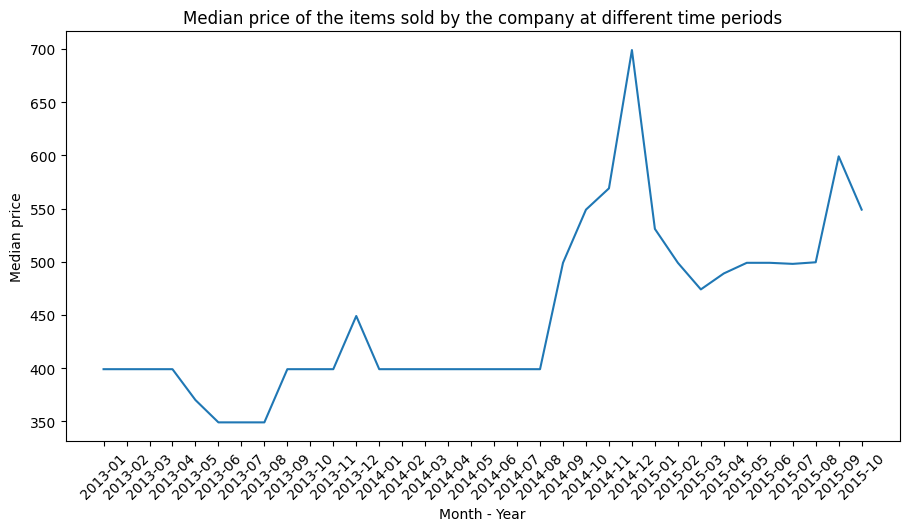

In [241]:
# Median price over time
price_over_my = sales_full[['month_year', 'item_price']].copy()
price_over_my = price_over_my.groupby('month_year').median()
price_over_my.reset_index(inplace = True)

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(price_over_my['month_year'], price_over_my['item_price'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Median price')
ax.set_title('Median price of the items sold by the company at different time periods')
plt.show()

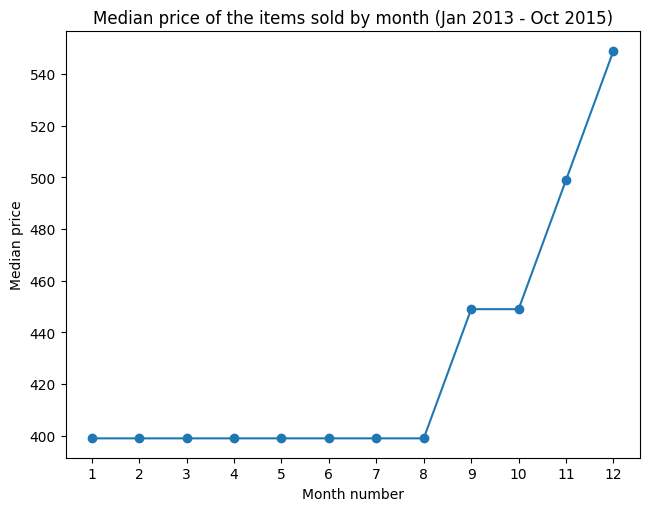

In [242]:
# Median price over months of the year
price_over_my = sales_full[['month', 'item_price']].copy()
price_over_my = price_over_my.groupby('month').median()
price_over_my.reset_index(inplace = True)

fig, ax = plt.subplots()
ax.plot(price_over_my['month'], price_over_my['item_price'], marker = 'o')
plt.tight_layout()

ax.set_xticks(range(1, 13, 1))
ax.set_xlabel('Month number')
ax.set_ylabel('Median price')
ax.set_title('Median price of the items sold by month (Jan 2013 - Oct 2015)')
plt.show()

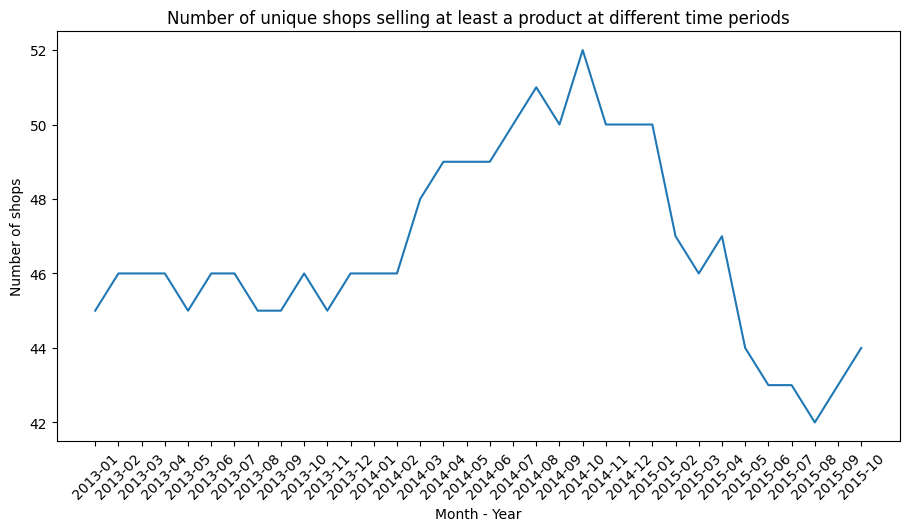

In [243]:
# Count number of distinct shops by month-year pair
shop_count_my = sales_full[['month_year', 'shop_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
shop_count_my = shop_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(shop_count_my['month_year'], shop_count_my['shop_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of shops')
ax.set_title('Number of unique shops selling at least a product at different time periods')
plt.show()

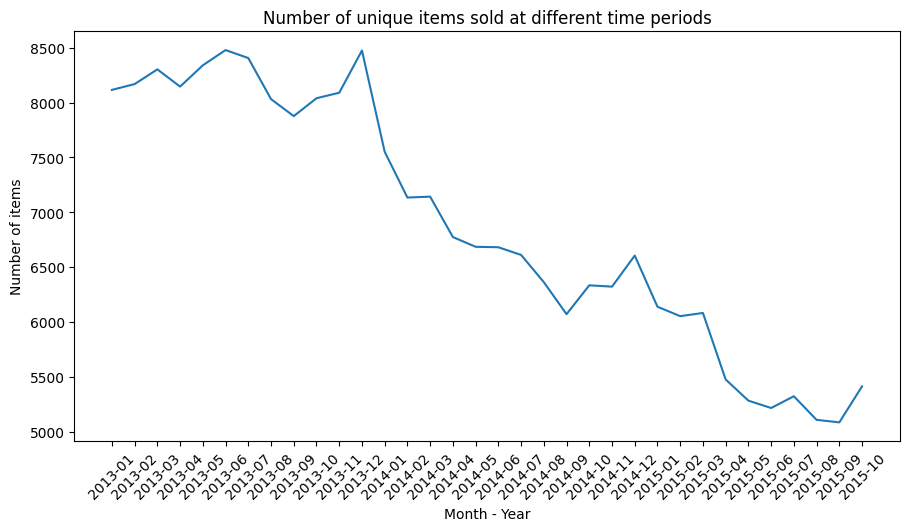

In [244]:
# Count number of distinct shops by month-year pair
shop_count_my = sales_full[['month_year', 'item_id']].groupby('month_year').nunique()
# .nunique() to denote that we only care about the number of distinct shops
shop_count_my = shop_count_my.reset_index()
# Move the month-year outside the index for more convenient plotting

fig, ax = plt.subplots(figsize = (9, 5))
ax.plot(shop_count_my['month_year'], shop_count_my['item_id'])
ax.tick_params(axis = 'x', labelrotation = 45)
plt.tight_layout()

ax.set_xlabel('Month - Year')
ax.set_ylabel('Number of items')
ax.set_title('Number of unique items sold at different time periods')
plt.show()

### VI. Test on different models

- https://scikit-learn.org/stable/auto_examples/applications/plot_cyclical_feature_engineering.html

- https://machinelearningcoban.com/tabml_book/ch_data_processing/hashing.html

- https://www.kaggle.com/code/avanwyk/encoding-cyclical-features-for-deep-learning

In [245]:
# Check data types again
sales_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 10 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   date_block_num  int64         
 2   shop_id         category      
 3   item_id         category      
 4   item_price      float64       
 5   item_cnt_day    float64       
 6   year            int32         
 7   month           int32         
 8   day             int32         
 9   month_year      object        
dtypes: category(2), datetime64[ns](1), float64(2), int32(3), int64(1), object(1)
memory usage: 154.7+ MB


In [246]:
# Group sales_train by month
sales_train_month = sales_train[['month_year', 'shop_id', 'item_id', 'item_cnt_day']].copy() # keep necessary columns only
sales_train_month['month_year'] = pd.to_datetime(sales_train_month['month_year'], format = '%Y-%m') # change to datetime format

# Take the total of daily sales to get monthly sales
sales_train_month = sales_train_month.groupby(['month_year', 'shop_id', 'item_id'], observed = True).sum()

# Changing table format to fit with the sample submission data
sales_train_month.reset_index(inplace = True)
sales_train_month = sales_train_month.rename(columns = {'item_cnt_day': 'item_cnt_month'})

sales_train_month.head()

,month_year,shop_id,item_id,item_cnt_month
0,2013-01-01,0,32,6.0
1,2013-01-01,0,33,3.0
2,2013-01-01,0,35,1.0
3,2013-01-01,0,43,1.0
4,2013-01-01,0,51,2.0


In [247]:
# Remove unnecessary columns from the sales_train data
sales_train_day = sales_train[['date', 'year', 'month', 'day', 'shop_id', 'item_id', 'item_price', 'item_cnt_day']].copy()
sales_train_day.drop_duplicates(inplace = True) # drop duplicates
sales_train_day.head()

,date,year,month,day,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,2013,1,2,59,22154,999.00,1.0
1,2013-01-03,2013,1,3,25,2552,899.00,1.0
2,2013-01-05,2013,1,5,25,2552,899.00,1.0
3,2013-01-06,2013,1,6,25,2554,1709.05,1.0
4,2013-01-15,2013,1,15,25,2555,1099.00,1.0


In [248]:
# Create a days in month column to encode the day variable later
sales_train_day['days_in_month'] = sales_train['date'].dt.days_in_month

# Encode month using trigonometric encoding for cyclical features
sales_train_day['month_sin'] = np.sin(sales_train_day['month'] / 12 * 2 * np.pi)
sales_train_day['month_cos'] = np.cos(sales_train_day['month'] / 12 * 2 * np.pi)

# Encode day - consider that each month has a different number of days
sales_train_day['day_sin'] = np.sin(sales_train_day['day'] / sales_train_day['days_in_month'] * 2 * np.pi)
sales_train_day['day_cos'] = np.cos(sales_train_day['day'] / sales_train_day['days_in_month'] * 2 * np.pi)

sales_train_day.head()

,date,year,month,day,shop_id,item_id,item_price,item_cnt_day,days_in_month,month_sin,month_cos,day_sin,day_cos
0,2013-01-02,2013,1,2,59,22154,999.00,1.0,31,0.5,0.866025,0.394356,0.918958
1,2013-01-03,2013,1,3,25,2552,899.00,1.0,31,0.5,0.866025,0.571268,0.820763
2,2013-01-05,2013,1,5,25,2552,899.00,1.0,31,0.5,0.866025,0.848644,0.528964
3,2013-01-06,2013,1,6,25,2554,1709.05,1.0,31,0.5,0.866025,0.937752,0.347305
4,2013-01-15,2013,1,15,25,2555,1099.00,1.0,31,0.5,0.866025,0.101168,-0.994869


Because the result of trigonometric scaling is from -1 to 1, I will use ```MinMaxScaler``` for the remaining numerical variables, which also shares the scale from -1 to 1.

In [249]:
sales_train_day['item_id'].nunique()

21807

In [250]:
# Feature hashing for categorical variables with multiple different values
from sklearn.feature_extraction import FeatureHasher

# Get frequency dictionary
from collections import Counter
item_counter = dict(Counter(sales_train_day['item_id'])) # the "Counter" method returns a Counter object by default

hasher = FeatureHasher(n_features = sales_train_day['item_id'].nunique(), dtype = np.int64)
# WORK IN PROGRESS